# Data Cleaning and Analytics


### Importing Data

In [46]:
from google.cloud import bigquery
from google.oauth2 import service_account
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

credentials = service_account.Credentials.from_service_account_file(
'data-finance-final-92d8049c252f.json')

project_id = 'data-finance-final'
client = bigquery.Client(credentials= credentials,project=project_id)

sql = "SELECT * FROM `data-finance-final.stockMetaData.stock_prices_cleaned`"

# Re-run the query
query_job = client.query(sql)
results = query_job.result()

# Convert results to a list
results_list = list(results)

# Convert the list of tuples to a list of lists
data_list = [list(row) for row in results_list]

# Convert the list of lists to a DataFrame with column names
column_names = ['date', 'open', 'high', 'low', 'close', 'volume', 'stock']
df = pd.DataFrame(data_list, columns=column_names)

#specify which stock you want
#stock = 'AAPL'
#df = df[df['stock'] == 'AAPL']
#df['date'] = pd.to_datetime(df['date'])
#df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Check for and handle any possible duplicates in the 'date' column
#df = df.drop_duplicates(subset='date')

# Sort the DataFrame by 'date'
#df = df.sort_values(by='date')


# Graphing for Cleaning

In [59]:
df.describe()

,open,high,low,close,volume
count,800.000000,800.000000,800.000000,800.000000,8.000000e+02
mean,182.485083,184.400177,180.620709,182.600612,4.004052e+07
std,86.501113,87.330252,85.589010,86.491484,3.674617e+07
min,32.230000,32.910000,32.020000,32.520000,1.640931e+06
25%,134.766800,136.396250,133.242500,135.030000,1.306773e+07
50%,165.640000,167.650000,164.295000,165.800000,2.860251e+07
75%,241.422500,244.405000,239.178175,241.695000,5.282563e+07
max,383.760000,384.300000,378.160000,382.700000,1.746679e+08


In [54]:
df['stock'].describe()

count     800
unique      8
top         V
freq      100
Name: stock, dtype: object

In [61]:
list(df['stock'].unique())

['V', 'IBM', 'AAPL', 'AMZN', 'GOOG', 'INTC', 'MSFT', 'TSLA']

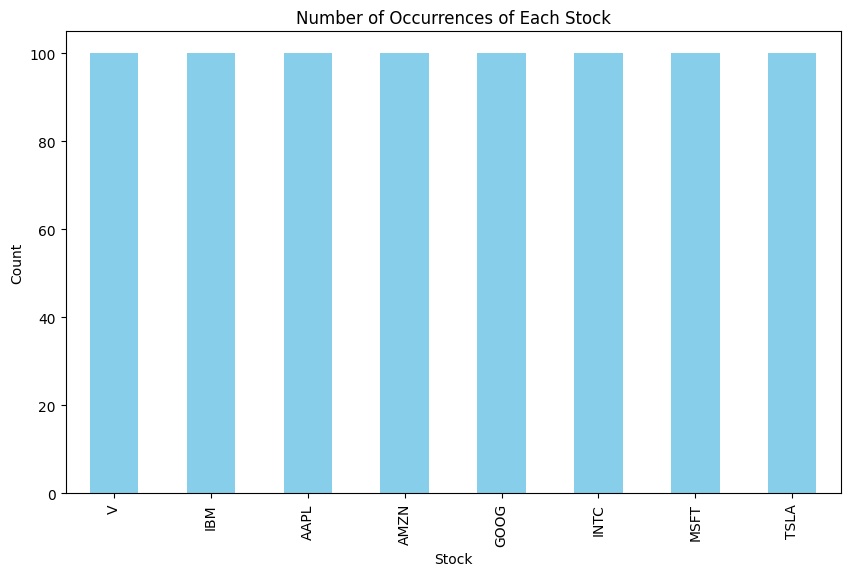

In [60]:
stock_counts = df['stock'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
stock_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Occurrences of Each Stock')
plt.xlabel('Stock')
plt.ylabel('Count')
plt.show()

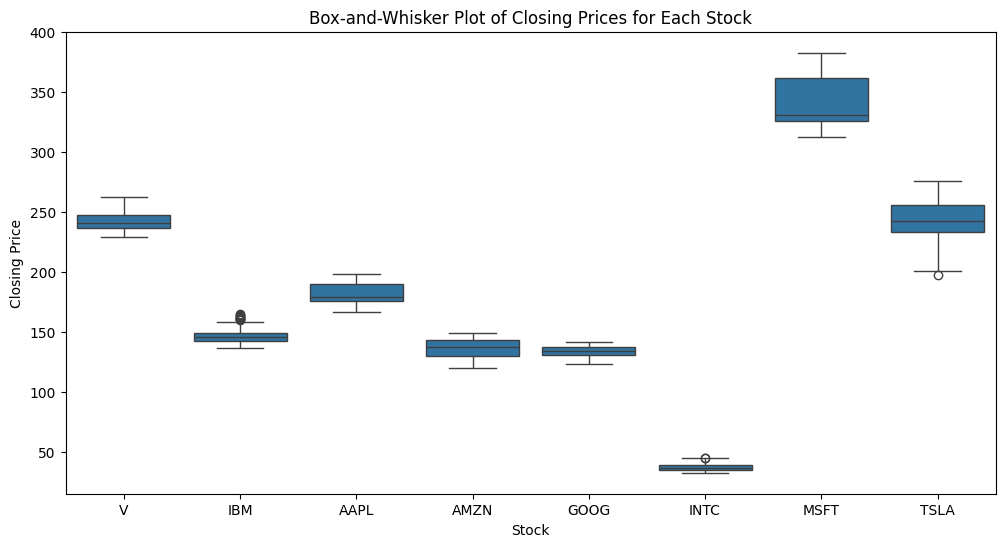

In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Create a box-and-whisker plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='stock', y='close', data=df)
plt.title('Box-and-Whisker Plot of Closing Prices for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Closing Price')
plt.show()


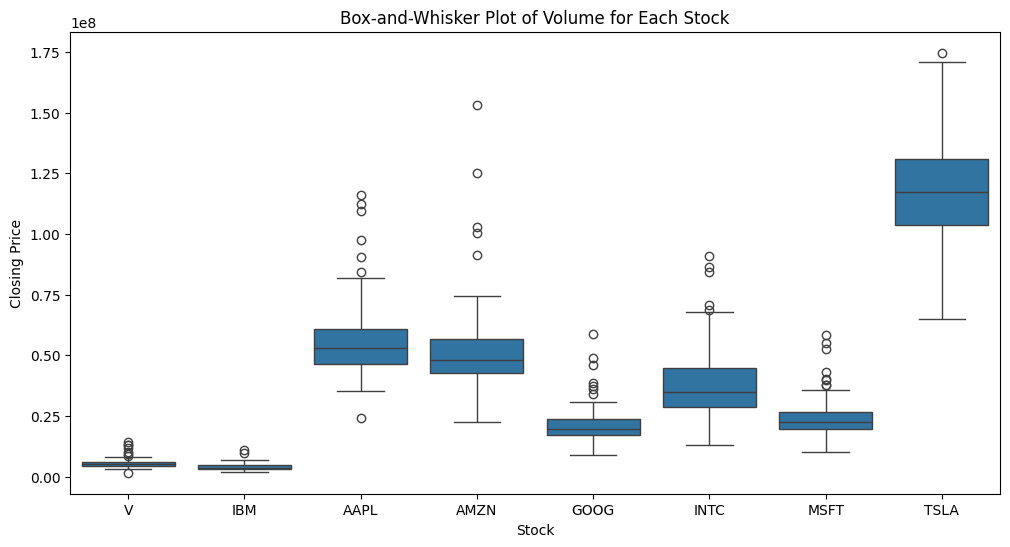

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a box-and-whisker plot using seaborn
plt.figure(figsize=(12, 6))
sns.boxplot(x='stock', y='volume', data=df)
plt.title('Box-and-Whisker Plot of Volume for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Closing Price')
plt.show()


# Predictive Analytics

## ARIMA

In [127]:
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# THis function runs the ARIMA model. It is optimized 
# df = dataframe object of the stock you want to predict
# pred_range = how many days you want to predict 
# p = 1, d = 0, q = 0 - these will be adjusted in the future daily by time series analysis to find best model

def arima_model(df,stock, pred_range,p,d,q): 
    #Loads the model 
    df = df[df['stock'] == stock]
    model = ARIMA(df['close'], order=(p,d,q))
    model_fit = model.fit()

    #Test####
    #print(model_fit.summary())
    
    #Time range 
    current_date = datetime.now().date() #- timedelta(days=1)
    # Format dates as strings in "YYYY-MM-DD" format
    start_index = current_date.strftime("%Y-%m-%d")

    ##Test####
    #print(current_date)
    #print(start_index)

    forecast_index = pd.date_range(start=start_index, periods=pred_range, freq='D')
    forecast_index = forecast_index.strftime("%Y-%m-%d")
    
    #Forecasting 
    forecast = model_fit.get_forecast(steps = pred_range)
    forecast_df = forecast.summary_frame()
    
    #Test pritn###
    #print(forecast_df.head())
    
    forecast_df['index'] = pd.to_datetime(forecast_index)
    #result['index'] = pd.to_datetime(result['date'])
    
    #Print forecast head
    #print(forecast_df.head())
    #print(df.tail())

    
    #### You can mess with the formatting but do not change the names of the DFs. 
    plt.figure(figsize=(15/2, 7/2))  # Modify this as needed for your data
    
    #May need to change 'index' to 'date' for df. NOT FORECAST
    # This takes the last 365 days from the price chart to reduce plot size 
    plt.plot(df['date'], df['close'], label='Closing Price', color='blue')
    plt.plot(forecast_df['index'], forecast_df['mean'], label='Predicted Price', color='red', linestyle='dashed')
    plt.fill_between(forecast_df['index'], forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='lightgray', label='95% Prediction Interval')
    
    # Format the date axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    
    # Rotate date labels
    plt.xticks(rotation=45)
    
    plt.title(f'ARIMA Prediction for \'{stock}\' Over {pred_range} days')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    
    plt.tight_layout()  # Adjust layout to fit the date labels
    plt.legend()
    plt.grid(True)


# This is the function that selects the best p, d, and q values for the ARIMA. It is run separately and once per day 
# so we can have the front end work quickly.
def optimal_arima(df,stock):
    df = df[df['stock'] == stock]
    train = df[:-20]
    test = df[-20:]
    train = train['close']
    test = test['close']
    
    best_score, best_cfg = float("inf"), None
    
    # Grid Search
    for p in range(5): 
        for d in range(2): 
            for q in range(5):
                order = (p,d,q)
                try:
                    model = ARIMA(train, order=(p,d,q))
                    model_fit = model.fit()
    
                    forecast = model_fit.forecast(steps = len(test))
                    error = mean_squared_error(test, forecast)
                    if error < best_score:
                        best_score, best_cfg = error, order
                except:
                    continue
    
    return best_cfg

In [138]:
optimal_arima(df,'GOOG')

(2, 0, 3)

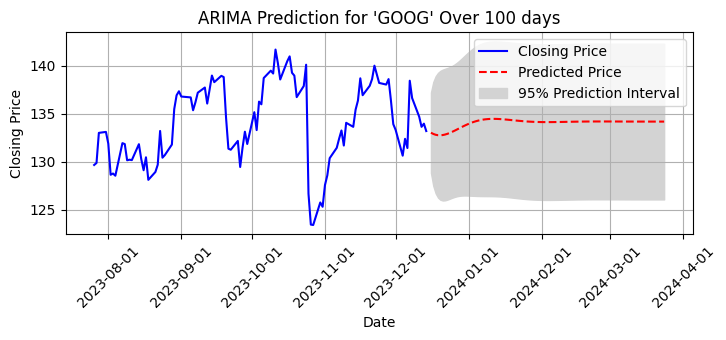

In [139]:
arima_model(df,'GOOG',100,2,0,3)

### FB Prophet

In [131]:
from sklearn.metrics import mean_squared_error

def prophet_model(df,stock,change_point,seasonality):
    warnings.filterwarnings('ignore')
    prophet_df = df[df['stock']==stock].rename({'date': 'ds', 'close': 'y'}, axis='columns')
    
    
    m = Prophet(changepoint_prior_scale = change_point,seasonality_prior_scale= seasonality,daily_seasonality=True )
    m.fit(prophet_df)
    
    future = m.make_future_dataframe(periods=100)
    forecast_ph = m.predict(future)
    pd.options.display.max_columns = None

    figure1 = m.plot(forecast_ph)
    figure2 = m.plot_components(forecast_ph)


def optimal_prophet(df,stock):
    warnings.filterwarnings('ignore')
    prophet_df = df[df['stock']==stock].rename({'date': 'ds', 'close': 'y'}, axis='columns')
    train = prophet_df.iloc[:-20]
    test = prophet_df.iloc[-20:]
    
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    }
    
    best_params = {}
    lowest_mse = float('inf')
    
    # Grid Search
    for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
        for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
            
            model = Prophet(daily_seasonality=True, 
                            changepoint_prior_scale=changepoint_prior_scale,
                            seasonality_prior_scale=seasonality_prior_scale)
            model.fit(train)
            
            future = model.make_future_dataframe(periods=20)
            forecast = model.predict(future)
            
            predicted = forecast['yhat'][-20:]
            mse = mean_squared_error(test['y'], predicted)
            
            if mse < lowest_mse:
                best_params = {'changepoint_prior_scale': changepoint_prior_scale,
                               'seasonality_prior_scale': seasonality_prior_scale}
                lowest_mse = mse
    
    return best_params




In [140]:
x = optimal_prophet(df, 'AAPL')
print(x)

18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:29 - cmdstanpy - INFO - Chain [1] done processing
18:42:29 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:30 - cmdstanpy - INFO - Chain [1] done processing
18:42:30 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1] done processing
18:42:31 - cmdstanpy - INFO - Chain [1] start processing
18:42:31 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


18:42:57 - cmdstanpy - INFO - Chain [1] start processing
18:42:57 - cmdstanpy - INFO - Chain [1] done processing


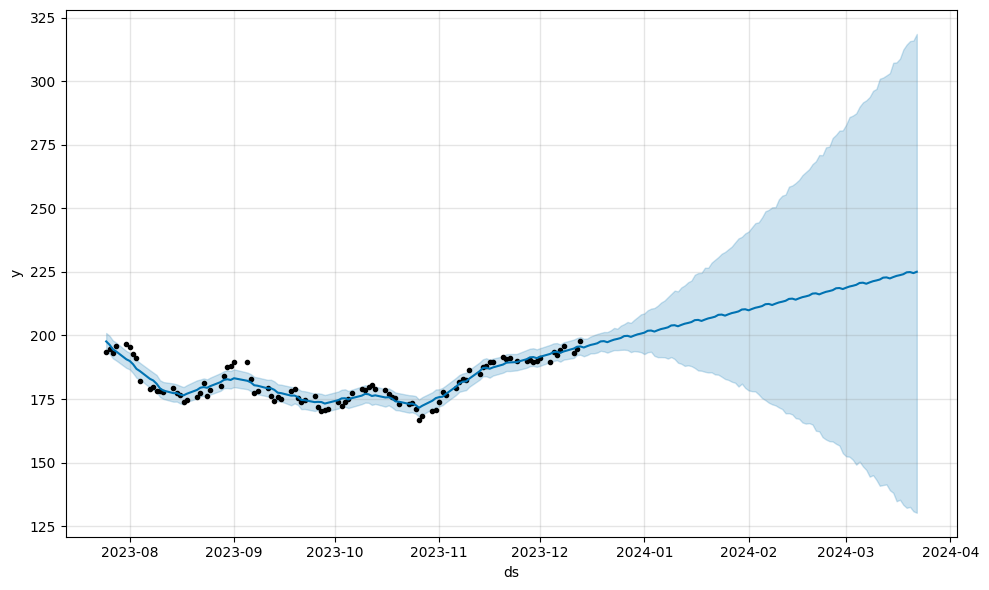

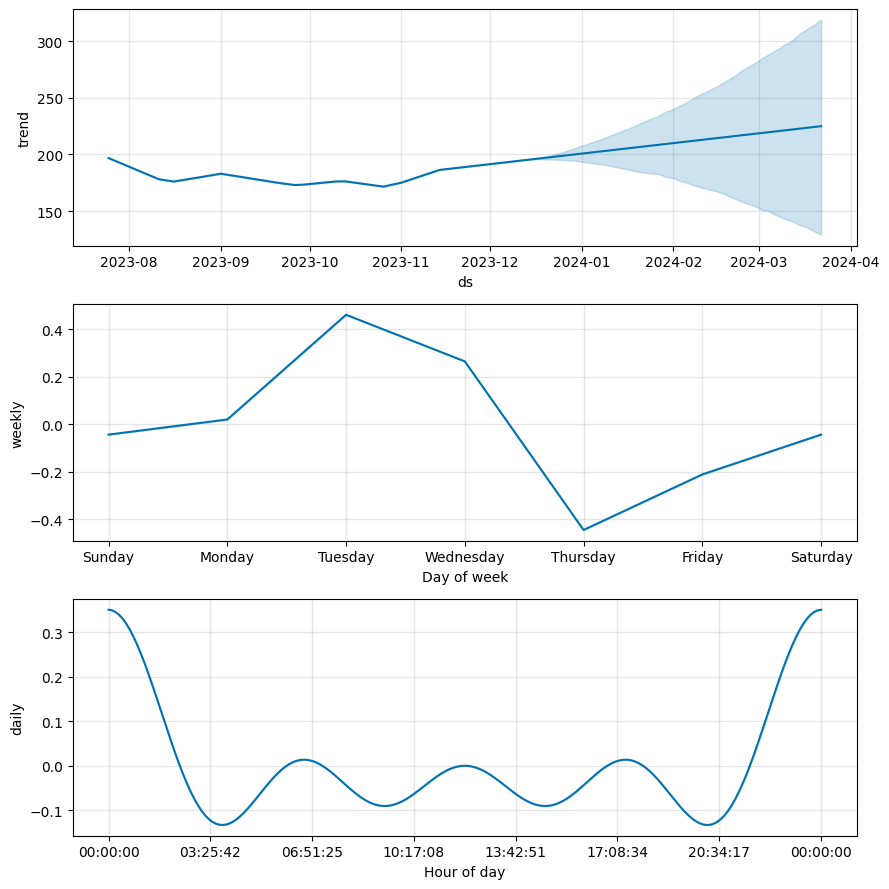

In [141]:
prophet_model(df,'AAPL',0.1,0.1)

# Facebook Prophet Modeling

In [105]:
from prophet import Prophet
from prophet.plot import plot_yearly


prophet_df = df[df['stock']=='V'].rename({'date': 'ds', 'close': 'y'}, axis='columns')


m = Prophet(changepoint_prior_scale = 0.01,seasonality_prior_scale= 0.1,daily_seasonality=True )
m.fit(prophet_df)

future = m.make_future_dataframe(periods=100)
forecast_ph = m.predict(future)
pd.options.display.max_columns = None



18:14:06 - cmdstanpy - INFO - Chain [1] start processing
18:14:06 - cmdstanpy - INFO - Chain [1] done processing


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

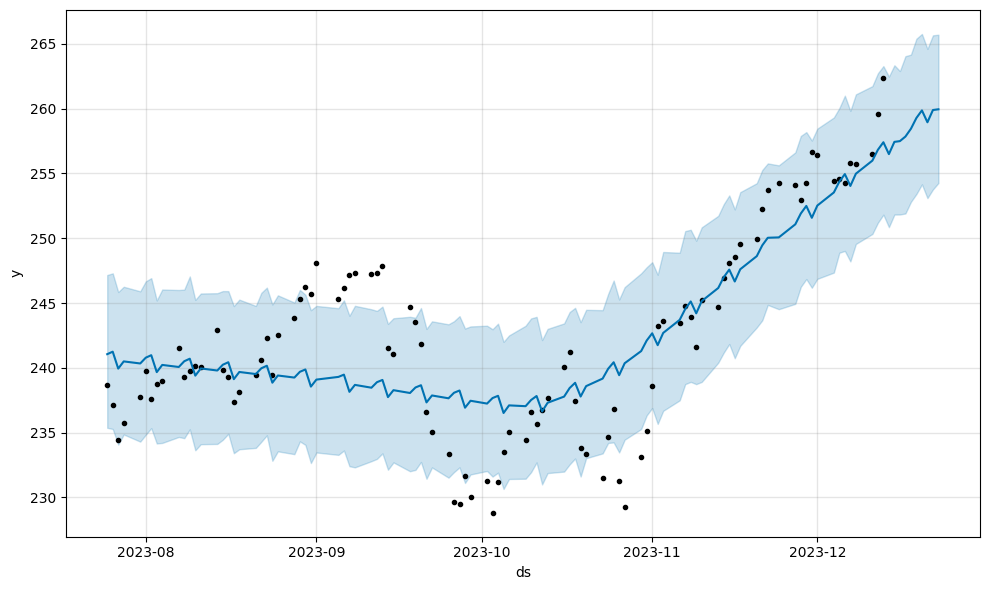

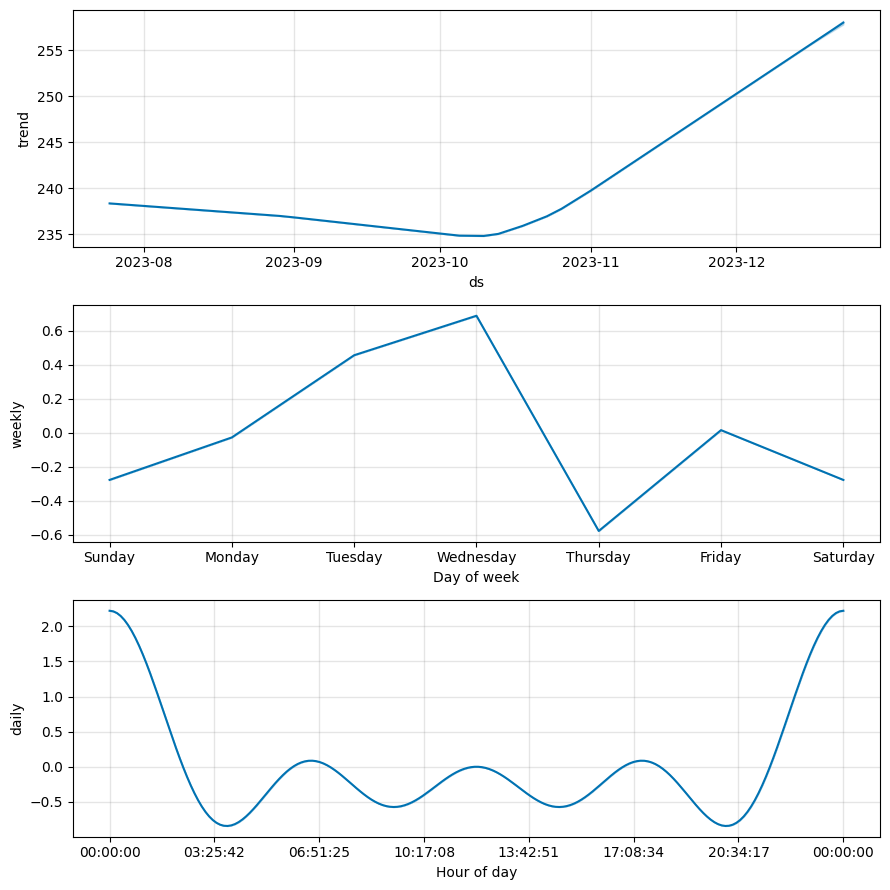

In [104]:
figure1 = m.plot(forecast_ph)
figure2 = m.plot_components(forecast_ph)

In [111]:

from sklearn.metrics import mean_squared_error



train = prophet_df.iloc[:-20]
test = prophet_df.iloc[-20:]

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

best_params = {}
lowest_mse = float('inf')

# Grid Search
for changepoint_prior_scale in param_grid['changepoint_prior_scale']:
    for seasonality_prior_scale in param_grid['seasonality_prior_scale']:
        
        model = Prophet(daily_seasonality=True, 
                        changepoint_prior_scale=changepoint_prior_scale,
                        seasonality_prior_scale=seasonality_prior_scale)
        model.fit(train)
        
        future = model.make_future_dataframe(periods=20)
        forecast = model.predict(future)
        
        predicted = forecast['yhat'][-20:]
        mse = mean_squared_error(test['y'], predicted)
        
        if mse < lowest_mse:
            best_params = {'changepoint_prior_scale': changepoint_prior_scale,
                           'seasonality_prior_scale': seasonality_prior_scale}
            lowest_mse = mse

print(best_params)


18:17:58 - cmdstanpy - INFO - Chain [1] start processing
18:17:58 - cmdstanpy - INFO - Chain [1] done processing
18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
18:17:59 - cmdstanpy - INFO - Chain [1] start processing
18:17:59 - cmdstanpy - INFO - Chain [1] done processing
18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:00 - cmdstanpy - INFO - Chain [1] done processing
18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:00 - cmdstanpy - INFO - Chain [1] done processing
18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:00 - cmdstanpy - INFO - Chain [1] done processing
18:18:00 - cmdstanpy - INFO - Chain [1] start processing
18:18:01 - cmdstanpy - INFO - Chain [1]

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}
